In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/repos/Computational-Physics-Intro/julia`


In [2]:
Pkg.add(["CairoMakie", "LinearAlgebra", "StatsBase"])

   Resolving package versions...
  No Changes to `~/repos/Computational-Physics-Intro/julia/Project.toml`
  No Changes to `~/repos/Computational-Physics-Intro/julia/Manifest.toml`
Precompiling project...
  ? DN


In [3]:
using CairoMakie, LinearAlgebra, StatsBase

In [4]:
mutable struct ODE
    f::Function
    #du::Vector{Float64}
    u0::Vector{Float64}
    p::Vector{Float64}
    tspan::Tuple{Float64, Float64}
    dt::Float64
    solver::Any
end

In [5]:
mutable struct ODESolution
    t::Vector{Float64}
    sol::Matrix{Float64}
end

In [6]:
function Euler(f, du, u, p, t, dt)
    u .= u .+ f(du, u, p, t)*dt
end

Euler (generic function with 1 method)

In [7]:
function Midpoint(f, du, u, p, t, dt)
    u .= u .+ f(du, u .+ dt.*f(du, u, p, t)./2, p, t+dt/2)*dt
end

Midpoint (generic function with 1 method)

In [10]:
function Heun(f, du, u, p, t, dt)
    u_int = u .+ f(du, u, p, t)*dt
    u .= u .+ dt*(f(du, u, p, t) + f(du, u_int, p, t+dt))/2
end

Heun (generic function with 1 method)

In [11]:
function RK4(f, du, u, p, t, dt)
    
    k1 = f(du, u, p, t)
    k2 = f(du, u .+ dt*k1./2, p, t+dt/2)
    k3 = f(du, u.+dt*k2./2, p, t+dt/2)
    k4 = f(du, u.+dt*k3, p, t+dt)
    u .= u .+ dt*(k1 .+ 2 .* k2 .+ 2 .* k3 .+ k4)./6

end

RK4 (generic function with 1 method)

In [12]:
function g(du, u, p, t)
    du[1] = u[1]^2 + 1
    return du
end

g (generic function with 1 method)

In [13]:
u0 = [0.0]
p = []

Any[]

In [14]:
function solve(ODE)
    #d = length(ODE.u0)
    t0, t1 = ODE.tspan
    u = vcat(ODE.u0')
    us = u
    du = zeros(length(us))
    for (i, t) in enumerate(t0:(ODE.dt):t1)
        ODE.solver(ODE.f, du, u, ODE.p, t, ODE.dt)
        us = vcat(us, u)
    end
    solution = ODESolution(collect(t0:ODE.dt:(t1+ODE.dt)), us)    
end

solve (generic function with 1 method)

In [15]:
prob1 = ODE(g, u0, p, (0., 1.6), 1e-2, Euler)
prob2 = ODE(g, u0, p, (0., 1.6), 1e-2, Midpoint)
prob3 = ODE(g, u0, p, (0., 1.6), 1e-2, Heun)
prob4 = ODE(g, u0, p, (0., 1.6), 1e-2, RK4)

ODE(g, [0.0], Float64[], (0.0, 1.6), 0.01, RK4)

In [16]:
s1 =solve(prob1)
s2 = solve(prob2)
s3 = solve(prob3)
s4 = solve(prob4)

ODESolution([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61], [0.010001000050003124; 0.010001000050003124; … ; Inf; Inf;;])

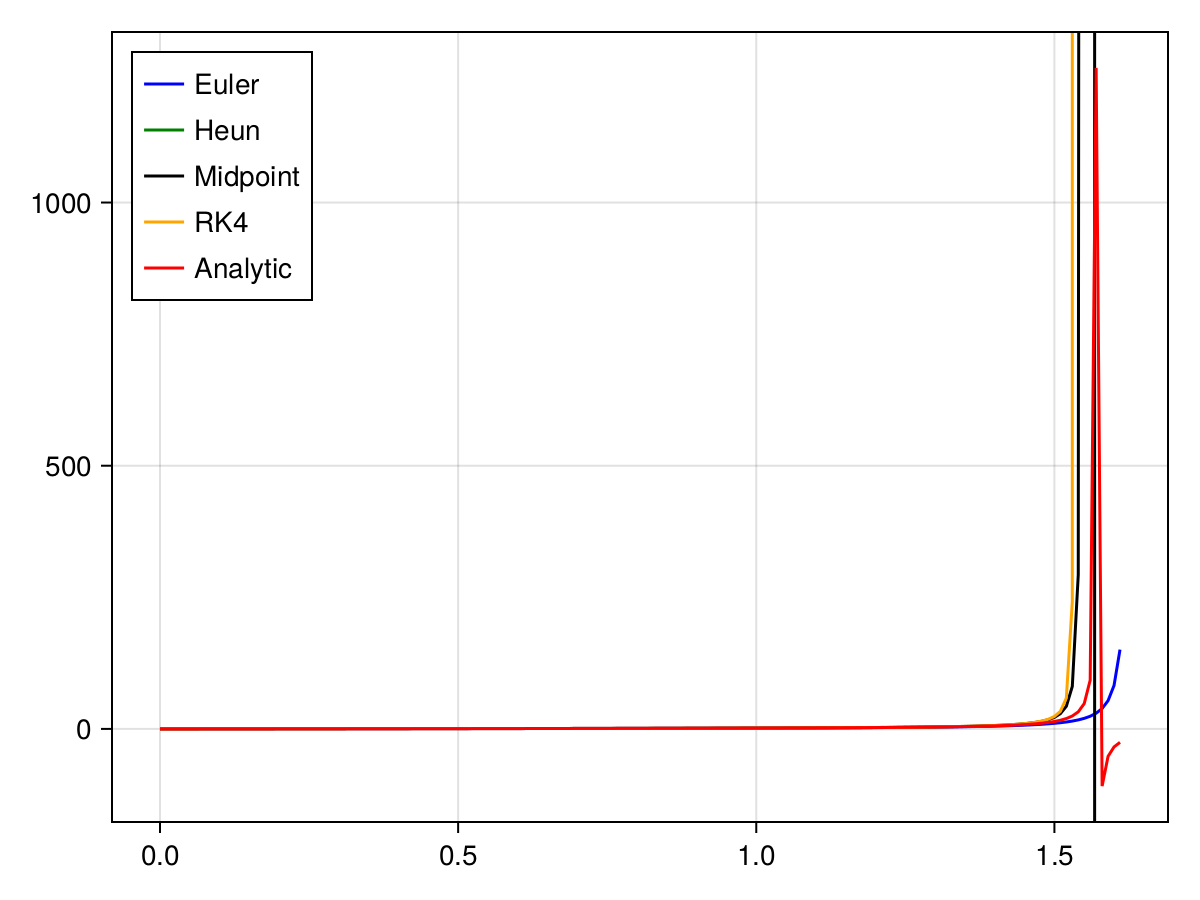

In [17]:
fig = Figure()
ax = Axis(fig[1, 1])
l1 = lines!(ax, s1.t,  s1.sol[:], color=:blue)
l2 = lines!(ax, s2.t,  s2.sol[:], color=:green)
l3 = lines!(ax, s3.t,  s3.sol[:], color=:black)
l4 = lines!(ax, s4.t,  s4.sol[:], color=:orange)
l5  = lines!(ax, s1.t, tan.(s1.t), color=:red)
Legend(fig[1, 1], [l1, l2, l3, l4, l5], ["Euler", "Heun", "Midpoint","RK4", "Analytic"], tellheight = false, tellwidth=false, margin=(10, 10, 10, 10), valign=:top, halign=:left)
fig

The same for second order problems

In [18]:
mutable struct SecondOrderProblem
    f::Function
    du0::Vector{Float64}
    u0::Vector{Float64}
    p::Vector{Float64}
    tspan::Tuple{Float64, Float64}
    dt::Float64
    solver::Any
end


# RK4 for second order ODE's

$$
\frac{d^2y}{dt^2} = f(\frac{dy}{dt}, y, t)
$$
redefine with $dy/dt = z$
$$
\frac{dz}{dt} = f(z, y, t) \
$$
$$
\frac{dy}{dt} = z
$$

In [19]:
function RK4(prob::SecondOrderProblem, du, u, p, t)
    dt = prob.dt
    k1 = prob.f(du, u, p, t)
    k2 = prob.f(du.+ dt*k1./2, u, p, t+dt/2)
    k3 = prob.f(du.+ dt*k2./2,u, p, t+dt/2)
    k4 = prob.f(du.+ dt*k3,u, p, t+dt)
    du .= du .+ dt*(k1 .+ 2 .* k2 .+ 2 .* k3 .+ k4)./6
    u .= u .+ du*dt
    return du, u
end

RK4 (generic function with 2 methods)

In [20]:
function Euler(prob::SecondOrderProblem, du, u, p, t)
    dt = prob.dt
    du .= du .+ dt*prob.f(du, u, p, t)
    u .= u .+ du*t 
    return du, u
end

Euler (generic function with 2 methods)

In [21]:
function LeapFrog(prob::SecondOrderProblem, du, u, p, t)
    dt = prob.dt
    a1 = prob.f(du, u, p, t)
    a2 = prob.f(du, u, p, t+dt)
    du .= du .+ (a1 .+ a2)*dt/2
    u .= u .+ du*dt .+ 0.5*a1*dt^2
    return du, u
end

LeapFrog (generic function with 1 method)

In [22]:
function projectile(du, u, p, t)
    return [-p[1]* norm(du)^(p[2]-1)*du[1], -p[3]-p[1]*norm(du)^(p[2]-1)*du[2]]
end

projectile (generic function with 1 method)

In [23]:
function solve(prob::SecondOrderProblem)
    du = prob.du0
    u = prob.u0
    us = [copy(u)]
    dus = [copy(du)]
    
    for t in prob.tspan[1]:prob.dt:prob.tspan[2]
        du, u = RK4(prob, du, u, p, t)
        push!(dus, du)
        push!(us, copy(u))
        
    end
    return us, dus
end

solve (generic function with 2 methods)

In [24]:
p = [1., 1., 9.81]

3-element Vector{Float64}:
 1.0
 1.0
 9.81

In [25]:
prob = SecondOrderProblem(projectile, [10. o, 10.], [0., 0.], p, (0., 1.4), 1e-1, RK4)
sol, dus = solve(prob);
xs = [el[1] for el in sol];
ys = [el[2] for el in sol];
xs

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/babaid/repos/Computational-Physics-Intro/julia/In[25]#1:45\[90mIn[25]:1:45[0;0m]8;;\
prob = SecondOrderProblem(projectile, [10. o[48;2;120;70;70m,[0;0m 10.], [0., 0.], p, (0., 1.4), 1e-1, RK4)
[90m#                                           ╙ ── [0;0m[91munexpected comma in array expression[0;0m

In [26]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, xs, ys, color=:blue)
x = [0, 0, 10, 10]
y = [0, -10, 0, -10]
xlims!(ax, (0, 10))
ylims!(ax,(0, 5))
poly!(ax, Point2f[(0, 0), (10, 0), (10, -10), (0, -10)], color=:black)
fig

LoadError: UndefVarError: `xs` not defined

# Planetary Motion

$$
\frac{d^2x}{dt^2} = -\frac{GM\cdot x}{r^3}, \frac{d^2y}{dt^2} = -\frac{GM\cdot y}{r^3}
$$

With the initial conditions: 
$$
x(0) = 0.5, y(0) =0, v_x(0) = 0, v_y(0)=1.63
$$



In [27]:
planet(du, u, p, t) = [-p[1]*u[1]/norm(u)^(1+p[2]), -p[1]*u[2]/norm(u)^(1+p[2])]

planet (generic function with 1 method)

In [28]:
p = [1., 2.]

2-element Vector{Float64}:
 1.0
 2.0

In [29]:
prob = SecondOrderProblem(planet, [0.0, 1.63], [0.5, 0.0], [1.], (0., 1000), 10e-1, LeapFrog)

SecondOrderProblem(planet, [0.0, 1.63], [0.5, 0.0], [1.0], (0.0, 1000.0), 1.0, LeapFrog)

In [30]:
@time sol, dus = solve(prob);
xs = [el[1] for el in sol];
ys = [el[2] for el in sol];
xs;

  0.388306 seconds (150.64 k allocations: 9.270 MiB, 6.86% gc time, 99.57% compilation time)


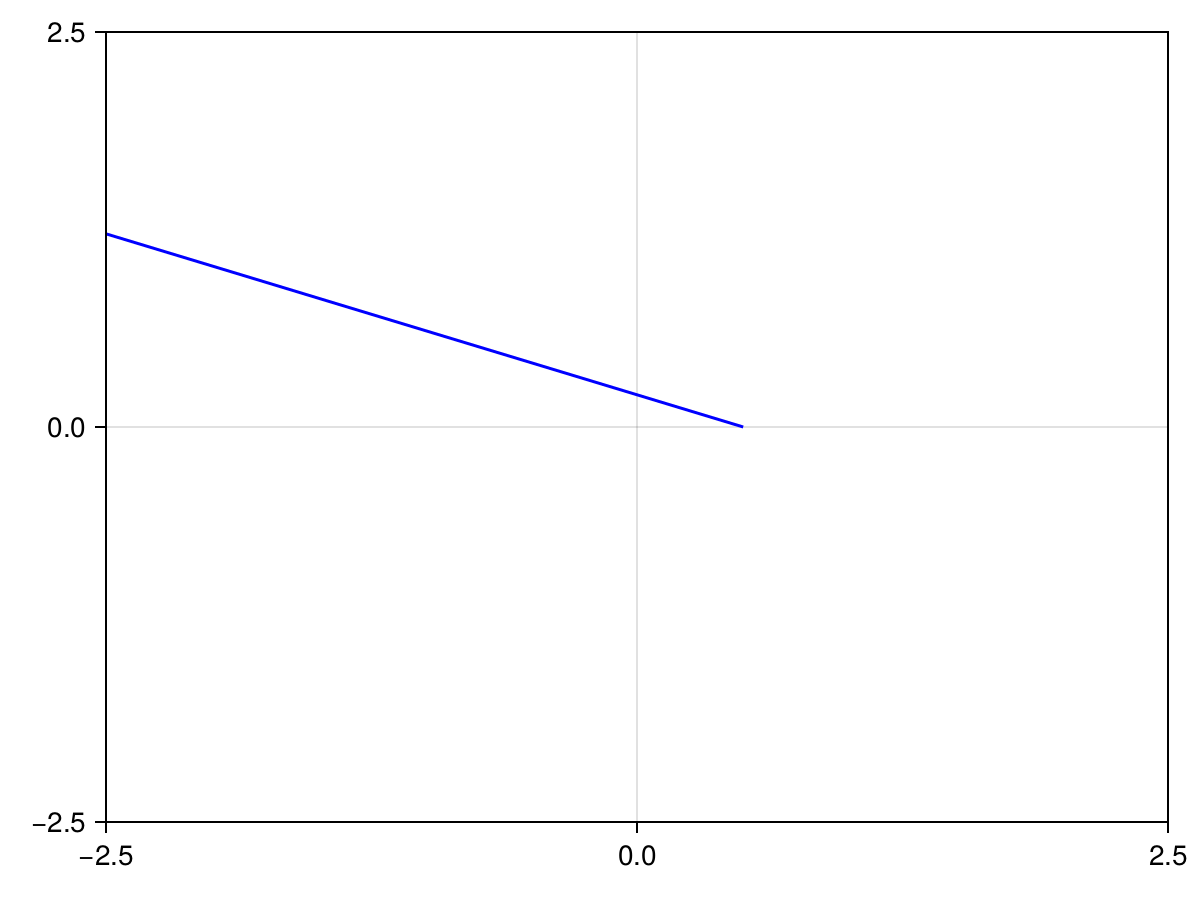

In [31]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, xs, ys, color=:blue)
x = [0, 0, 10, 10]
y = [0, -10, 0, -10]
xlims!(ax, (-2.5, 2.5))
ylims!(ax,(-2.5, 2.5))
fig

#  A quantum well

$$
V(x) = \begin{cases} V_0 &  |x| <a \\ 0 & |x|>a
\end{cases}
$$

Schrödinger equation:

$$
-\frac{\hbar^2}{2m}\frac{\partial^2 \psi}{\partial x^2} + V(x) \psi = i\hbar \frac{\partial \psi}{\partial t}
$$

Rewritten:

$$
\frac{\partial^2 \psi(x, t)}{\partial x^2}  = \frac{2m}{\hbar^2} \Bigg[-i\hbar \frac{\partial \psi(x, t)}{\partial t} +  V(x) \psi(x, t) \Bigg]
$$


$$
-\frac{\hbar^2}{2m}\frac{\partial^2 u(x)}{\partial x^2} + V(x) u(x) = E u(x)
$$
and
$$
i\hbar \frac{\partial T(t)}{\partial t} = E T(t)
$$
______________


Stationary equation:

$$
\frac{\partial^2 u(x)}{\partial x^2} =-0.0483 \Big[ E  -  V(x)\Big]u(x)
$$


$$
197.29 i \frac{\partial T(t)}{\partial t} = E T(t)
$$

In [32]:
function V(x)
    if abs(x)<2
        return -85.
    else
        return 0.0
    end
end

V (generic function with 1 method)

In [160]:
qmw(du, u, p, t) = -p[1]*u + sin(u)/

qmw (generic function with 1 method)

In [161]:
E = -15

-15

In [162]:
b = exp(-5*sqrt(-0.0483*E))
c = sqrt(-0.0483*E)*exp(-5*sqrt(-0.0483*E))

0.012070207575955873

In [163]:
prob = SecondOrderProblem(qmw, [b], [c], [0.0483, E], (-5., 5.), 1e-2, RK4)

SecondOrderProblem(qmw, [0.014180630600674942], [0.012070207575955873], [0.0483, -15.0], (-5.0, 5.0), 0.01, RK4)

In [168]:
@time sol, dus = solve(prob);
xs = -5:1e-2:5.01
ys = [el[1] for el in sol];
du_s = [el[1] for el in dus] 
xs;

  0.002156 seconds (36.05 k allocations: 1.479 MiB)


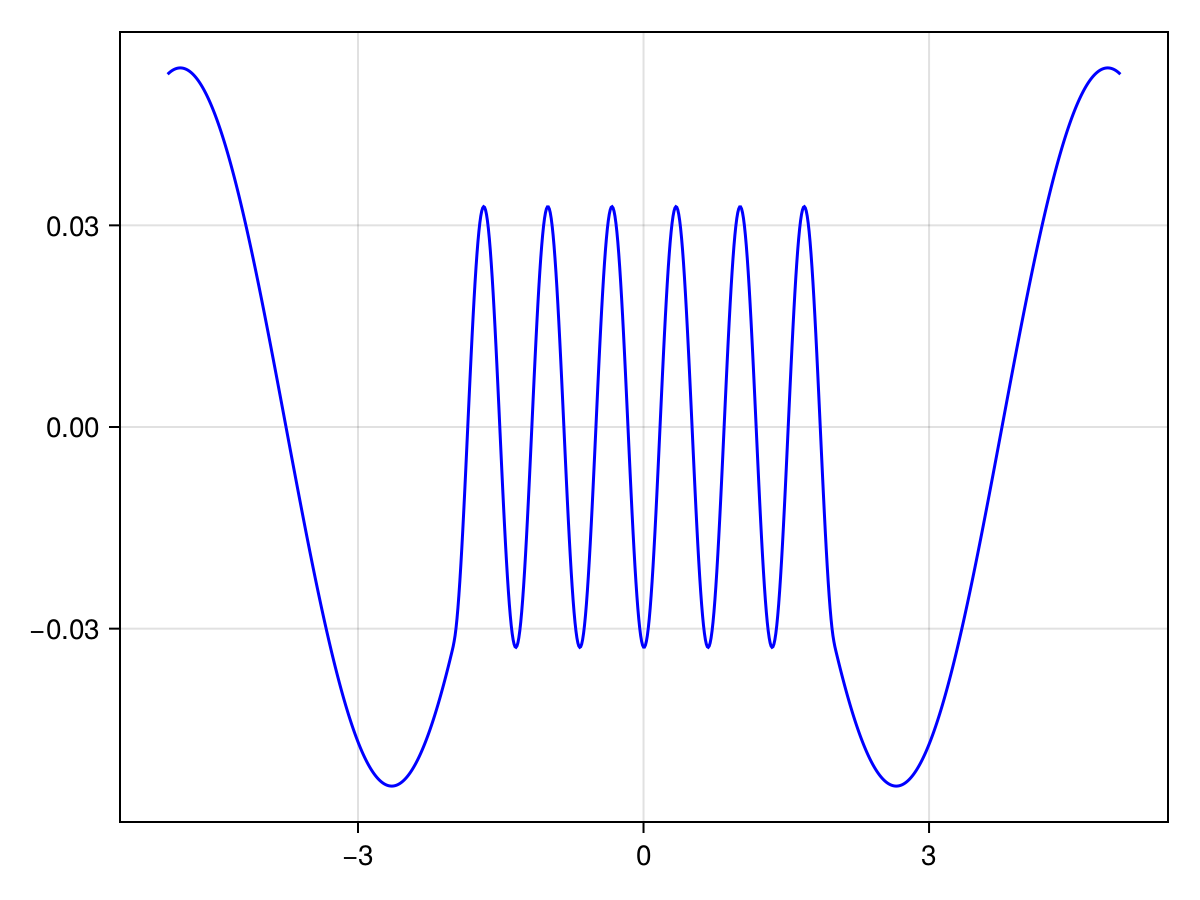

In [180]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, xs, ys+reverse(ys) , color=:blue)
x = [0, 0, 10, 10]
#y = [0, -10, 0, -10]
#xlims!(ax, (-2.5, 2.5))
#ylims!(ax,(-2.5, 2.5))
fig

# Fourier transform method for Schrödinger equation